<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Image_Segmentation_Contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Competition!
**Author**: W. Tod Newman

**Updates**: New Version

## Problem

Use a U-Net (or other approach) to predict an image mask that can be used to segment an image from its background.

## Metrics

This competition is evaluated on the intersection over union (IoU) metric.  The IOU metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

## Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

## Objective

In this competition, the objective is to maximize the mean IOU metric on the validation data, which measures the performance of the segmenter.  U-Net is given as an example, but isn't the only way to solve the segmentation problem.  You may evaluate techniques to squeeze more performance out of the U-Net, or you might even try a completely different model, neural network or otherwise.  You will note that there are tips/tricks/techniques documented in many locations on the internet that could be useful.

## Rules and Timeline

The primary measure for the competition will be maximization of the mean IOU metric on the validation data.  Ties will be broken by a subjective assessment by the class of performance on the test images (last 2 blocks of this notebook)

The results will be revealed at the end of Day 4 (all-virtual classes) or during lunch of day 2 (in-person classes).  Please submit your top val_mean_iou score (ex: loss: 0.4397 - mean_iou: 0.4477 - val_loss: 0.4266 - val_mean_iou: 0.4713) to instructors before the time set up for the revealing of results.

A prize will be given to the top finisher(s) based on the judgement of the instructor and the availability of prizes.  Of course, for all-virtual classes, the prize will be the recognition of your achievement and ranking on the RSpace page!

To submit your results, submit your best val_mean_iou line (EXAMPLE: i= 5 loss= 0.3709357976913452 val_loss= 0.34795916080474854 mean_iou= 0.5377999544143677 val_mean_iou= 0.5530663132667542) to wtnewman@raytheon.com before the end of class.


# U-Net Overview

For this competition, we provide a working U-Net example code.  A U-Net is a very common network used for the problem of image segmentation.

A U-Net is a simple fully-convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

## Download Data

Download the images/masks and unzip the files 

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

We download the files into the images folder and the annotations folder (for the masks)

## Data Generators

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

## Set up image generators

We'll also do a 95% test/train split here

In [ ]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

## Grab one image and then plot the image, the mask and the combination of image*mask.

This is here largely to demonstrate how we're using images, masks, and combinations of images & masks.

In [ ]:
x, y= next(train_generator)

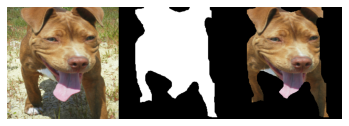

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

## Define the IoU metric

Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.  It is frequently used in Image detection where there is a truth label (a bounding box, for instance) and a predicted label (the predicted bounding box). 

Essentially what the algorithm is doing is taking a ratio of the intersection of the true and the predicted regions to the union of the two regions.  Therefore, if the two bounding boxes (or in this case, segmentations) align perfectly, IOU is maximum.

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

## Model

Here's where we define the U-Net model.  Note that this is a fairly simple U-net.

In [ ]:
learning_rate = .001

def unet(sz = (256, 256, 3)):
    x = Input(sz)
    inputs = x
  
    # Down-sampling (contraction block)
    f = 6
    layers = []
  
    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2  # Next layer will have 2x the filters
    ff2 = 64 
  
    # Bottleneck - this is the bottom of the U.  It mediates between the down-sampling
    # (contraction) and the up-sampling (expansion) parts of the network.

    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)

    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
  
    # Upsampling (Expansion Block)
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
         
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 
    
  
    # Classification  Block
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    
    outputs = Conv2D(1, 1, activation='sigmoid') (x)

    # Define the optimizer to use for backpropagation.  Adam is a commonly-used Optimizer.
    optimizer = keras.optimizers.Adam(lr=learning_rate)
  
    # Model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model

In [ ]:
model = unet()

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 6)  168         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 6)  330         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 6)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
def build_callbacks():
        modelCP = ModelCheckpoint(filepath='tod_unet.h5', 
                                  monitor='val_mean_iou', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  period=1)
        LR = ReduceLROnPlateau(monitor='val_mean_iou', 
                        patience=5, 
                        verbose=1, 
                        factor=0.3, 
                        min_lr=0.00001)
        callbacks = [modelCP, PlotLearning(), LR]
        return callbacks



# inheritance for training process plot.  We'll include this as a callback as we fit the model.
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

What we're doing here is training a model to predict the masks for the images.  Then we'll test them on our unique test set.

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
219/219 [==============================] - 91s 327ms/step - loss: 0.5269 - mean_iou: 0.1284 - val_loss: 0.4565 - val_mean_iou: 0.4144
i= 1 loss= 0.5268639922142029 val_loss= 0.45647308230400085 mean_iou= 0.1283656805753708 val_mean_iou= 0.4144324064254761


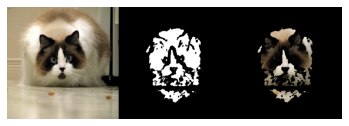

Epoch 2/5
219/219 [==============================] - 70s 320ms/step - loss: 0.4314 - mean_iou: 0.4617 - val_loss: 0.4097 - val_mean_iou: 0.4402
i= 2 loss= 0.4313984215259552 val_loss= 0.40974244475364685 mean_iou= 0.4617339074611664 val_mean_iou= 0.4402080476284027


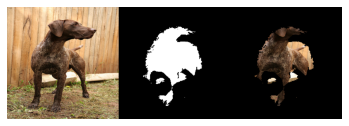

Epoch 3/5
219/219 [==============================] - 70s 322ms/step - loss: 0.4052 - mean_iou: 0.4917 - val_loss: 0.3999 - val_mean_iou: 0.4669
i= 3 loss= 0.40515899658203125 val_loss= 0.39987945556640625 mean_iou= 0.4916691780090332 val_mean_iou= 0.466899037361145


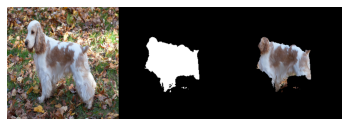

Epoch 4/5
219/219 [==============================] - 70s 323ms/step - loss: 0.3892 - mean_iou: 0.5149 - val_loss: 0.3931 - val_mean_iou: 0.4339
i= 4 loss= 0.38923507928848267 val_loss= 0.39312025904655457 mean_iou= 0.5148799419403076 val_mean_iou= 0.4338647127151489


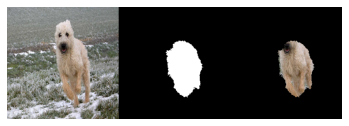

Epoch 5/5
219/219 [==============================] - 70s 322ms/step - loss: 0.3709 - mean_iou: 0.5378 - val_loss: 0.3480 - val_mean_iou: 0.5531
i= 5 loss= 0.3709357976913452 val_loss= 0.34795916080474854 mean_iou= 0.5377999544143677 val_mean_iou= 0.5530663132667542


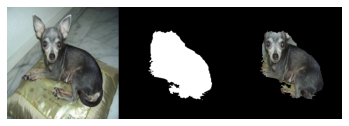

In [ ]:
# Define the Number of Epochs to Train Over
num_epochs = 5

# Fit the Model
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator, 
                    epochs = num_epochs, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

# Testing

Now we're going to clone my test images from the GitHub.  These include images that may be inside or outside the domain the masks were trained in.  As you'll see, some of them still work.

In [ ]:
!git clone https://github.com/todnewman/images /content/test_images

Cloning into '/content/test_images'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 34 (delta 4), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (34/34), done.


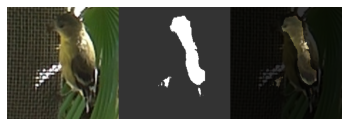

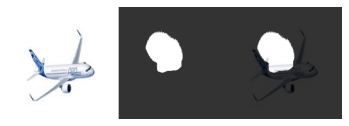

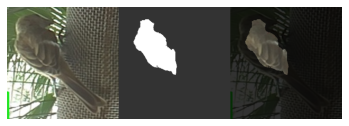

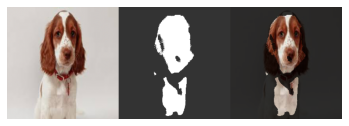

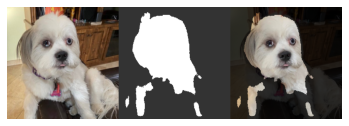

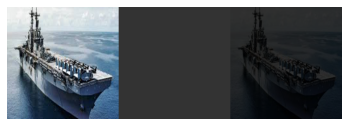

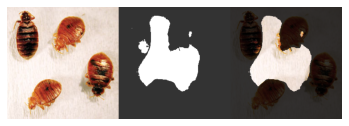

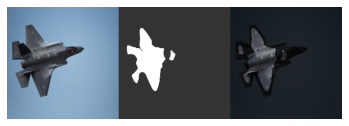

In [ ]:
import os
directory = '/content/test_images'

for file in os.listdir(directory):
    if file.endswith(".jpg"):
        f = (os.path.join(directory, file))

        raw = Image.open(f)
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0.2 # make this zero if you want solid black background

        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

